# TD SENSITIVITY ANALYSIS PART 1

In this TD we will use some methods of sensitivity analysis. In the first part of the TD a simple model will be used to handle the code to apply these methods. Then the studient will have to adapt these method to an FSPM model, see TD_Sensitivity_Part2

### load/install the packages

In [68]:
packs <- c( "sensitivity", "lhs", "ggplot2",'dplyr','ggrepel','plotly')
InstIfNec<-function (pack) {
  if (!do.call(require,as.list(pack))) {
    do.call(install.packages,as.list(pack))  }
  do.call(require,as.list(pack)) }
lapply(packs, InstIfNec)



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

# Using the methods in a simple example
Let's consider a simple model with 4 parameters a, b , c and d using the following function: $y=a+2b+b^2 - (c+d)^2$

In [69]:
# define the function
simple.model=function(a,b,c,d){
  y=a+2*b+b**2-(c+d)**2
  return(y)
}

Let's run N simulations with independent random sampling in uniform laws fro each parameters (we consider parameters range from 0 to 10)

In [70]:
# fixe N
N=1000

# create the data table
don=data.frame(a=runif(n =N,min=0,max = 10),
               b=runif(n =N,min=0,max = 10),
               c=runif(n =N,min=0,max = 10),
               d=runif(n =N,min=0,max = 10))

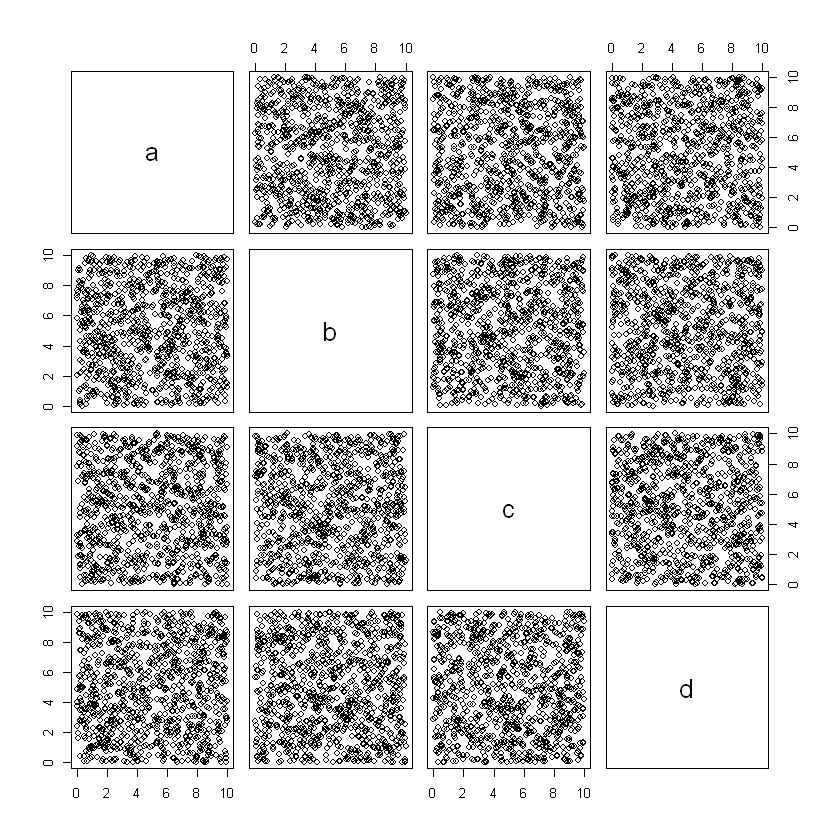

In [71]:

### visualize the sampling

plot(don)

#### $\Rrightarrow$ Here we can see that the sampling fills the whole space

In [72]:
### simulate the N predictions of the simple model

##here we use the mutate founction of dplyr to calculate and add a new variable (=model outputs) in the data frame

don=don%>%
  dplyr::mutate(y=simple.model(a,b,c,d)) 


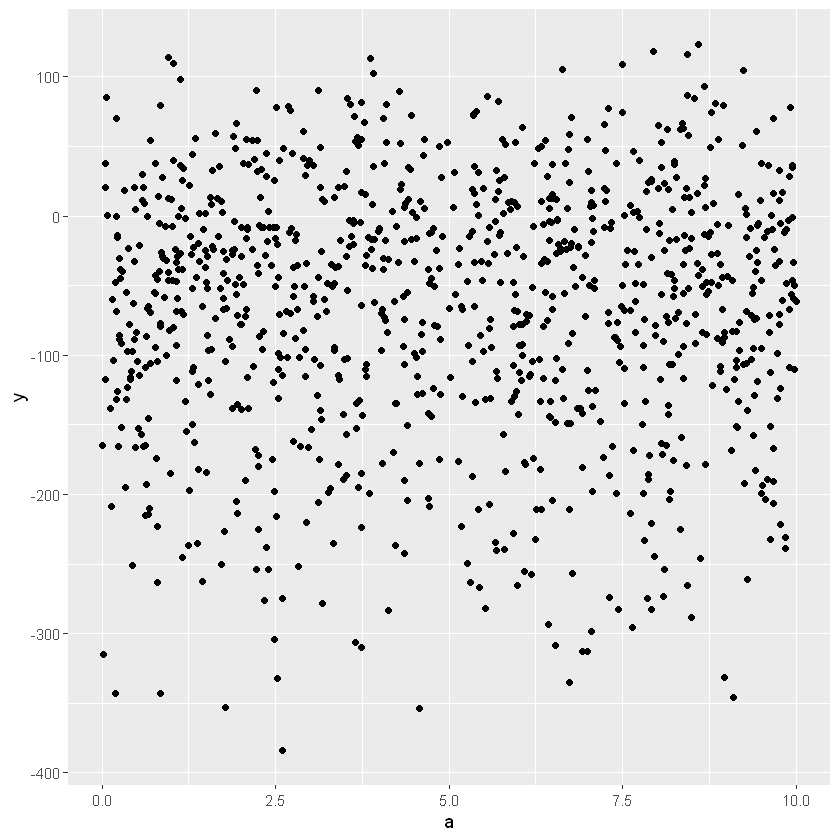

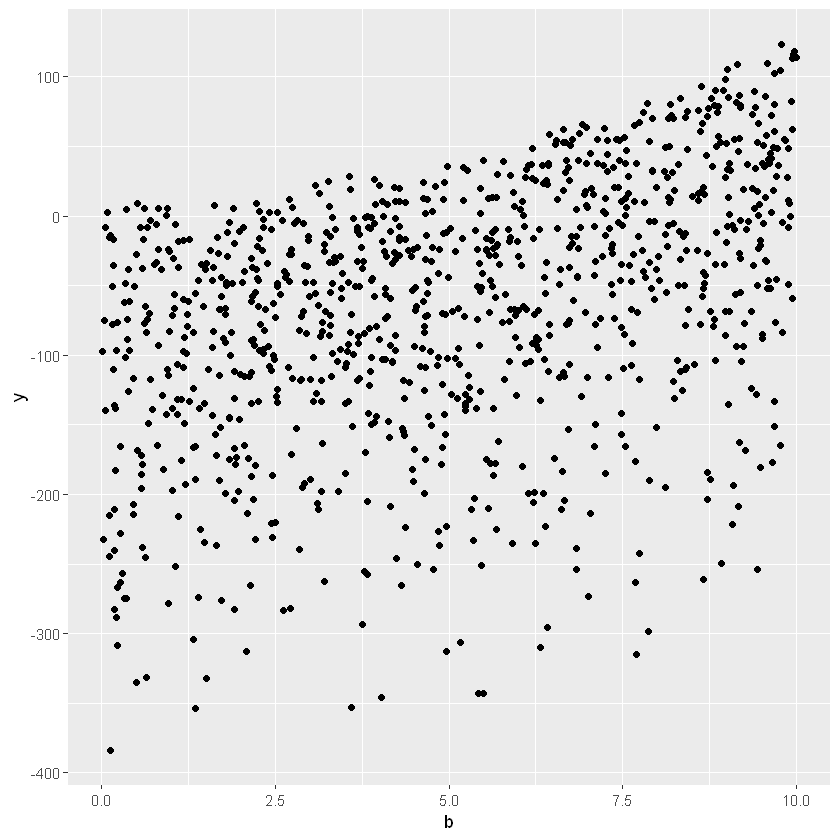

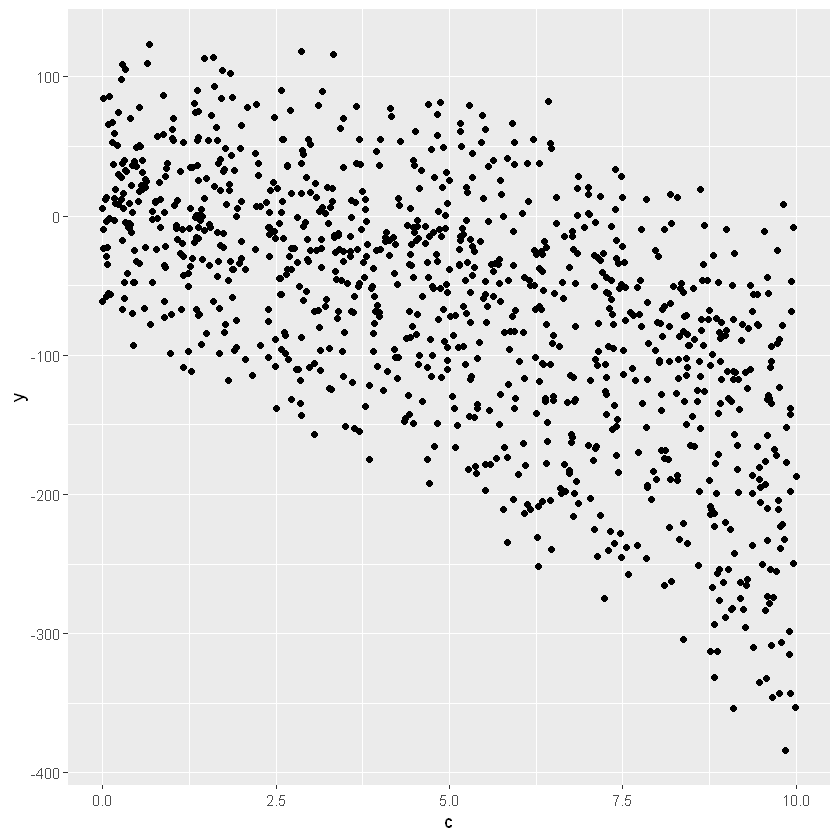

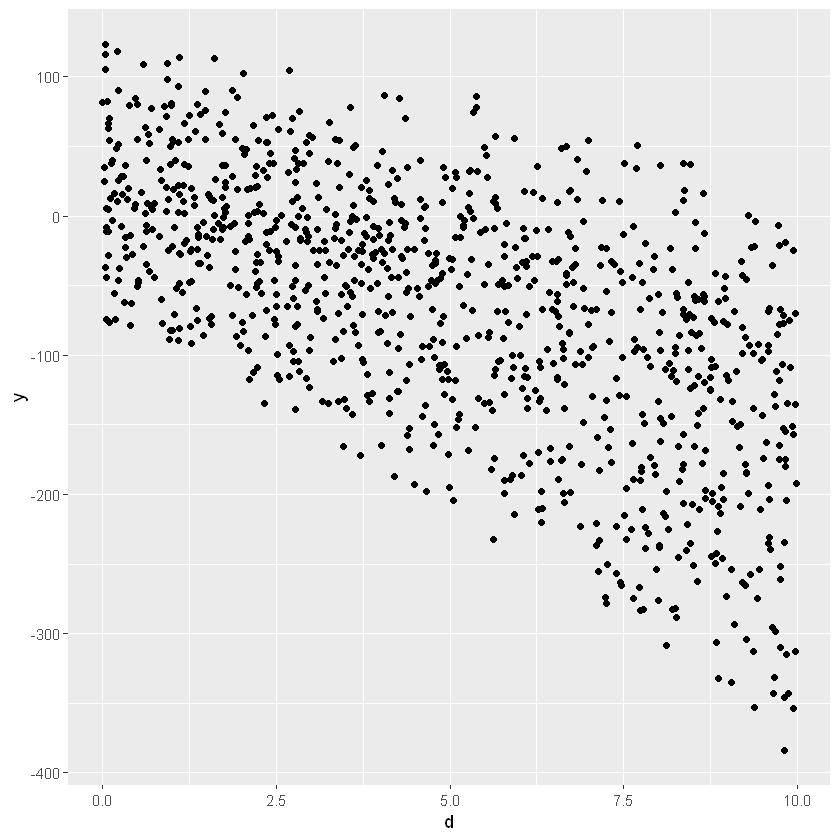

In [73]:
### visualize the response of the simple model to each parameters variation
for (p in c('a','b','c','d')){
  gr=don%>%
    ggplot(aes(x=get(p),y=y))+
    geom_point()+
    xlab(p)
  print(gr)
}

## 1. Application using analysis of variance from a complete factorial plan

In [74]:
parameters= c('a','b','c','d')
### let s discretize inputs in 6 value from 0 to 10

seq=seq(0,10,2)
plan.complet <- expand.grid(a = seq, 
                            b = seq,
                            c = seq, 
                            d =seq)

print(paste('Sample size =',nrow(plan.complet)))

[1] "Sample size = 1296"


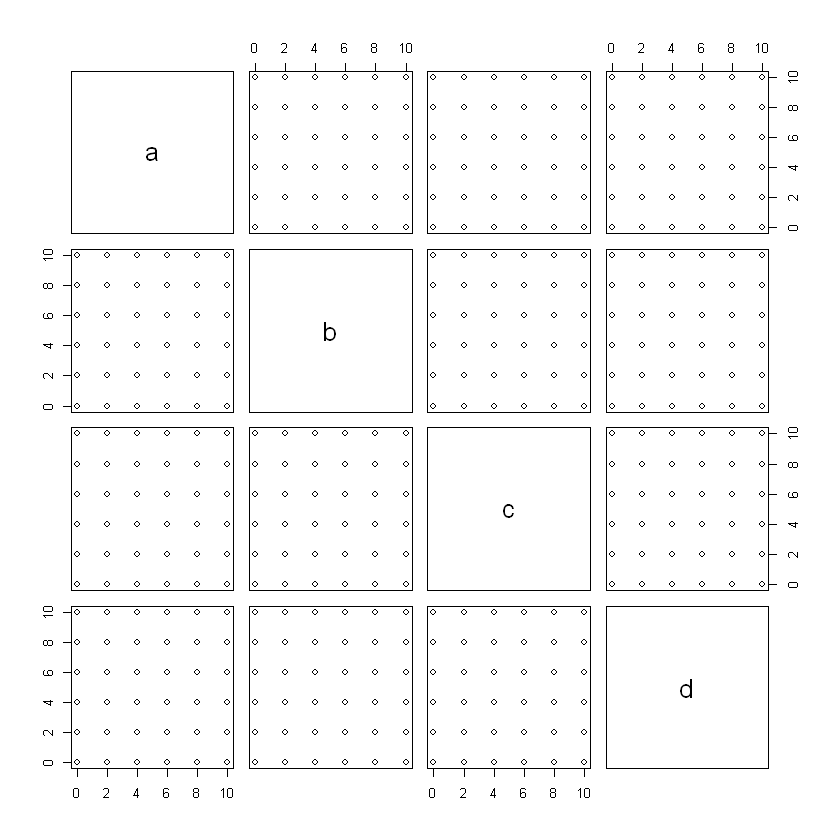

In [75]:
### visualize the sampling design
plot(plan.complet)

In [76]:
### calculate prediction for each set of inputs
plan.complet=plan.complet%>%
  mutate(y=simple.model(a,b,c,d))


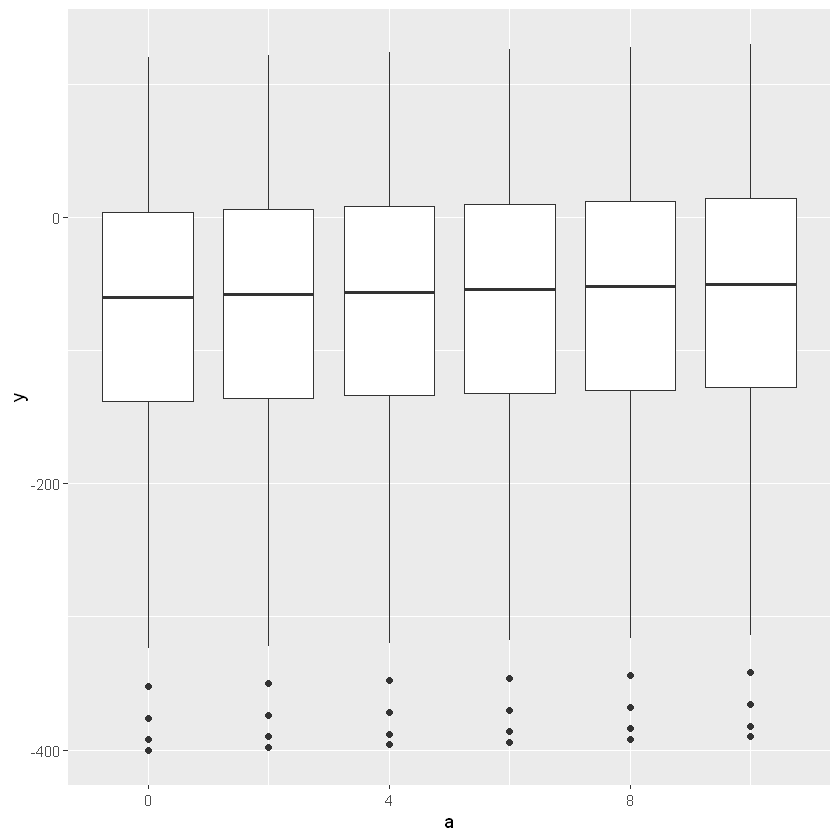

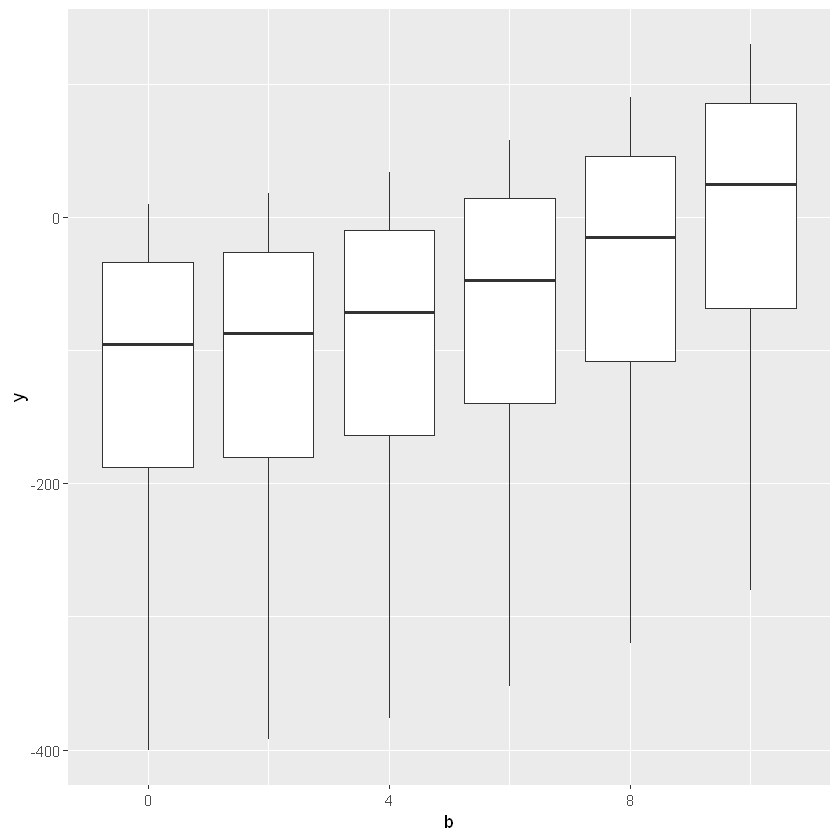

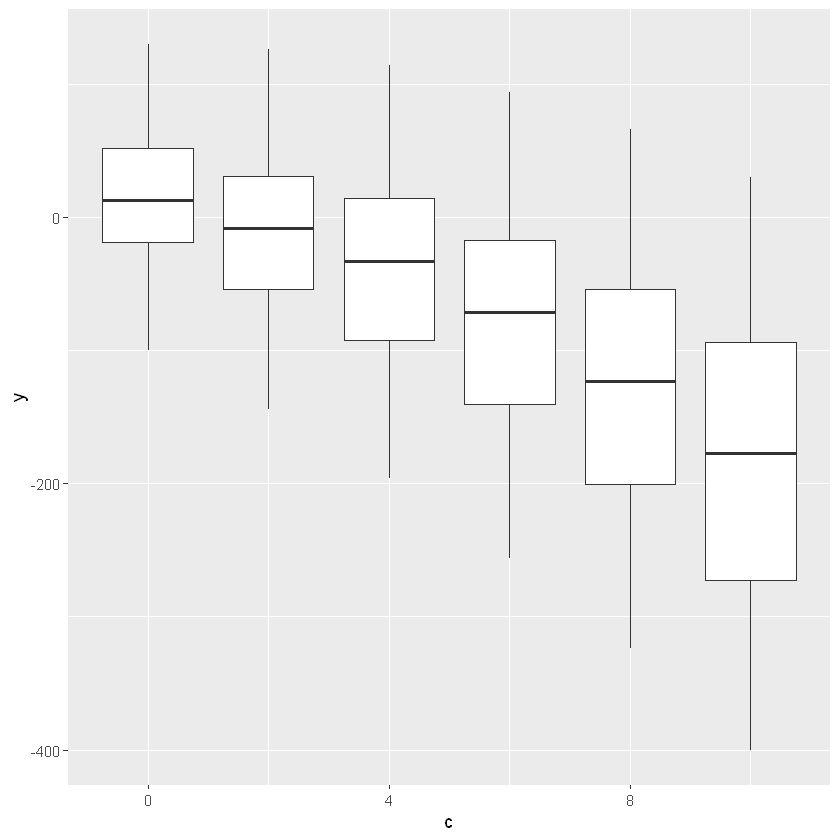

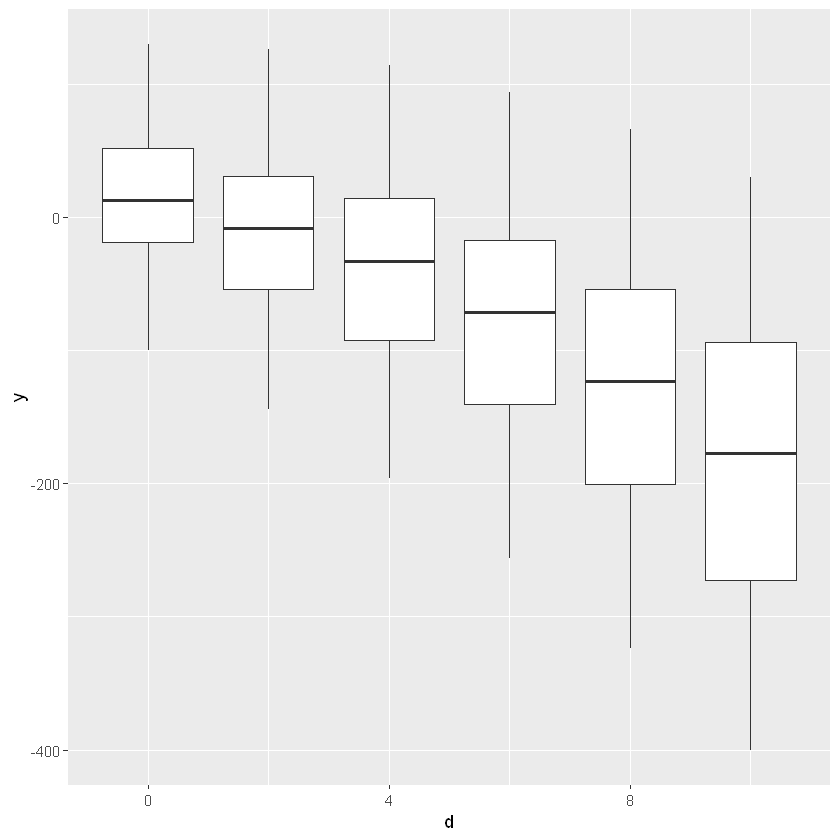

In [77]:
### visualize the response of the simple model to each parameters variation
for (p in parameters){
  gr2=plan.complet%>%
    ggplot(aes(x=get(p),y=y, group=get(p)))+
    geom_boxplot()+
    xlab(p)
  
  print(gr2)
}

In [78]:
## analysis of variance
complet.aov <- aov(y ~ (a+b+c+d)^3,data=plan.complet)
complet.table <- print(summary(complet.aov))

              Df  Sum Sq Mean Sq  F value   Pr(>F)    
a              1   15120   15120    50.04 2.47e-12 ***
b              1 2177280 2177280  7205.62  < 2e-16 ***
c              1 6048000 6048000 20015.62  < 2e-16 ***
d              1 6048000 6048000 20015.62  < 2e-16 ***
a:b            1       0       0     0.00        1    
a:c            1       0       0     0.00        1    
a:d            1       0       0     0.00        1    
b:c            1       0       0     0.00        1    
b:d            1       0       0     0.00        1    
c:d            1  705600  705600  2335.16  < 2e-16 ***
a:b:c          1       0       0     0.00        1    
a:b:d          1       0       0     0.00        1    
a:c:d          1       0       0     0.00        1    
b:c:d          1       0       0     0.00        1    
Residuals   1281  387072     302                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


#### As expected first order effects of each parameters and the interaction between c and d are significant 

In [79]:
### total variance explained 
r2_aov=summary(lm(formula=plan.complet$y~predict(complet.aov)))$adj.r.squared

print(paste('The total variance explained by the anava model is ', r2_aov))

[1] "The total variance explained by the anava model is  0.974815076069835"


In [80]:
## estimating the contribution of each term to the explained variance

nfac=ncol(plan.complet)-1  ###number of parameters
SS <- complet.table[[1]][2] ##Sum Sq

neffets <- nrow(SS)-1 ## number of effects estimates

SS.fac <- SS[1:neffets,] ## vector of Sum Sq
SStot <- sum(SS.fac)  ### total Sum Sq

## affect effect to each parameter
vv <- terms(y ~ (a+b+c+d)^3,
            keep.order = F)
vv1 <- attr(vv, "factors")

### % of variance explained for each parameter
Itot <- rep(NA,nfac) ; Iprinc<- SS.fac[1:nfac]/SStot
for(i in 1:nfac) {
  Itot[i] <- sum(SS.fac[vv1[i+1,]==1])/SStot}
M <- rbind(Iprinc,Itot-Iprinc)


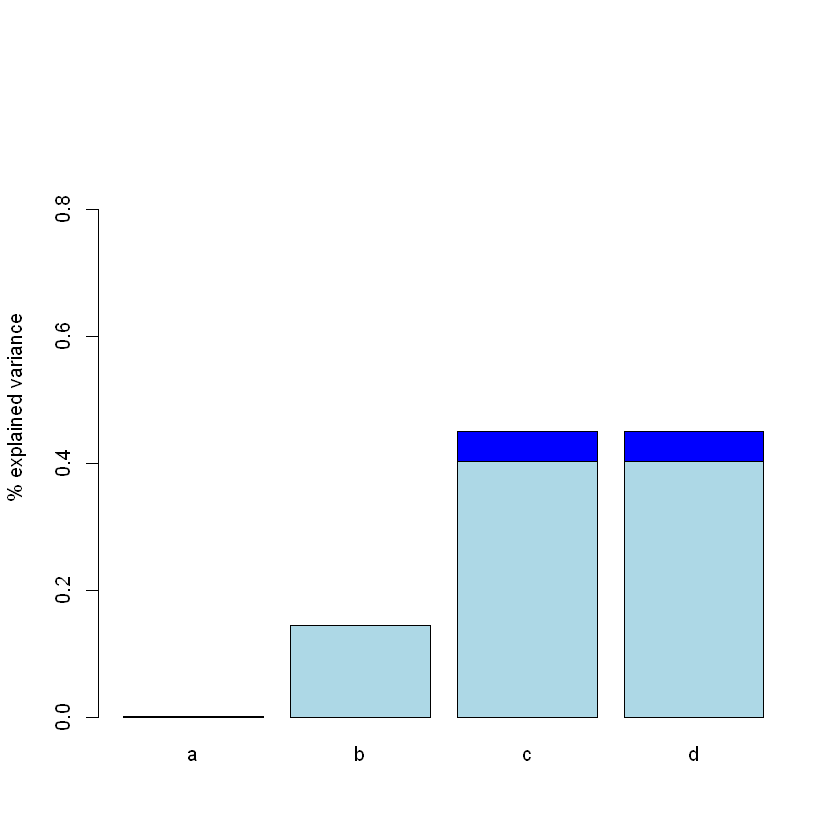

In [81]:
### vizualise  the contribution of parameters to the variance explained
barplot( M,col=c("lightblue","blue"),
         names.arg = colnames(plan.complet)[1:nfac],ylab = '% explained variance',ylim = c(0,r2_aov))


#### $\Rrightarrow$ The decomposition of variance stresses the high effects of b,c and d. Interactions are also detected for c and d.

## 2. Application using the Morris' method

In [82]:
# generate the data fram
parameters=c('a','b','c','d')

Pvar=data.frame(parameter=parameters,min=NA,max=NA) #generate a data frame
rownames(Pvar)=parameters

###fix  min and max paramater values for each parameter
#param a
Pvar['a',c('min','max')]=c(0,10) 
#param b
Pvar['b',c('min','max')]=c(0,10) 
#param c 
Pvar['c',c('min','max')]=c(0,10)
#param d
Pvar['d',c('min','max')]=c(0,10)  

#check the data frame
print(Pvar)

  parameter min max
a         a   0  10
b         b   0  10
c         c   0  10
d         d   0  10


### Design the Morris plan

In [83]:
# number of factors (parameters)
nFact= parameters

#number of trajectories
r=30

#inf limit
binf=Pvar[,'min']; names(binf)=parameters
#sup limit 
bsup=Pvar[,'max'];names(bsup)=parameters
#discretisation levels
Q=5
#discretisation step
step=2

#set random seed
RNGkind(kind="L'Ecuyer-CMRG")
set.seed(1) 

#plan
etude.morris=morris(model=NULL,factors=as.character(nFact),r=r,design=list(type='oat',levels=Q, grid.jump=step),scale=T,binf= binf,bsup=bsup)

planMorris=etude.morris$X


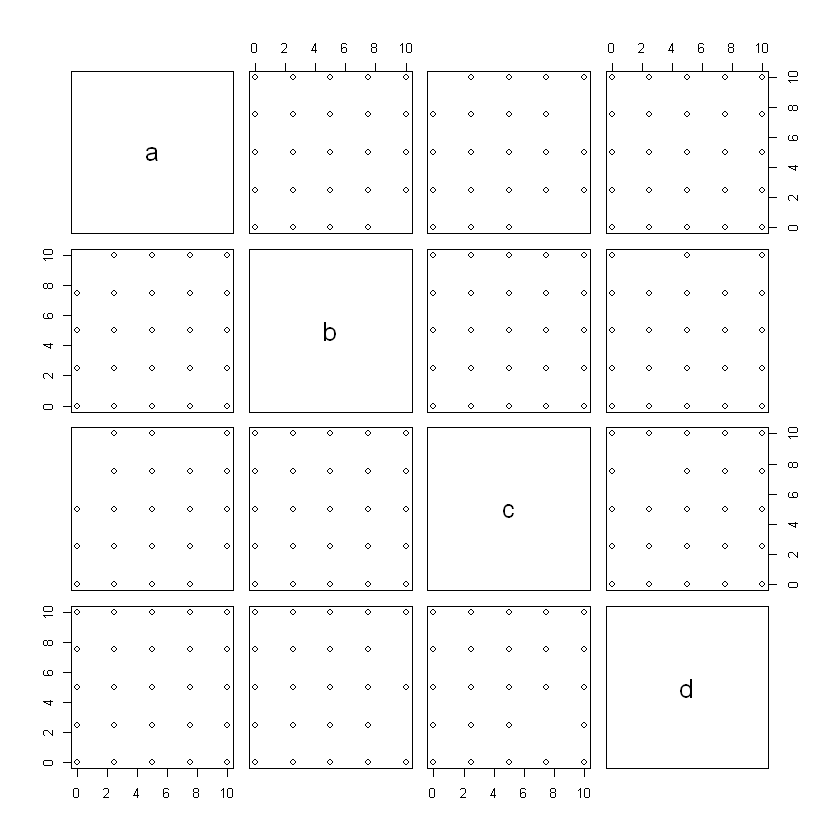

In [84]:
### visualize the sampling
plot(as.data.frame(planMorris))


In [85]:
### visualize trajectories (example on one trajectory)

###select the trajectories
visuTraj=planMorris%>%
  as.data.frame()%>%
  mutate(sim=row_number())%>%
  mutate(trajectory=sim%/%6)%>%
  filter(trajectory<3)%>%
mutate(trajectory=paste('t',trajectory))

p=plotly::plot_ly(visuTraj, x = ~a, y = ~b, z = ~c, type = "scatter3d", 
                mode = "lines+markers",symbol=~trajectory,color=~d,line = list(width = 4), 
                size = 3)

embed_notebook(p)  ###NB: by clicking on trajectories legend you can isolate one trajectorie for a better visualisation

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+DQo8aHRtbD4NCjxoZWFkPg0KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+DQo8dGl0bGU+cGxvdGx5PC90aXRsZT4NCjxzY3JpcHQgc3JjPSJkYXRhOmFwcGxpY2F0aW9uL2phdmFzY3JpcHQ7YmFzZTY0LEtHWjFibU4wYVc5dUtDa2dld29nSUM4dklFbG1JSGRwYm1SdmR5NUlWRTFNVjJsa1oyVjBjeUJwY3lCaGJISmxZV1I1SUdSbFptbHVaV1FzSUhSb1pXNGdkWE5sSUdsME95QnZkR2hsY25kcGMyVWdZM0psWVhSbElHRUtJQ0F2THlCdVpYY2diMkpxWldOMExpQlVhR2x6SUdGc2JHOTNjeUJ3Y21WalpXUnBibWNnWTI5a1pTQjBieUJ6WlhRZ2IzQjBhVzl1Y3lCMGFHRjBJR0ZtWm1WamRDQjBhR1VLSUNBdkx5QnBibWwwYVdGc2FYcGhkR2x2YmlCd2NtOWpaWE56SUNoMGFHOTFaMmdnYm05dVpTQmpkWEp5Wlc1MGJIa2daWGhwYzNRcExnb2dJSGRwYm1SdmR5NUlWRTFNVjJsa1oyVjBjeUE5SUhkcGJtUnZkeTVJVkUxTVYybGtaMlYwY3lCOGZDQjdmVHNLQ2lBZ0x5OGdVMlZsSUdsbUlIZGxKM0psSUhKMWJtNXBibWNnYVc0Z1lTQjJhV1YzWlhJZ2NHRnVaUzRnU1dZZ2JtOTBMQ0IzWlNkeVpTQnBiaUJoSUhkbFlpQmljbTkzYzJWeUxnb2dJSFpoY2lCMmFXVjNaWEpOYjJSbElEMGdkMmx1Wkc5M0xraFVUVXhYYVdSblpYUnpMblpwWlhkbGNrMXZaR1VnUFFvZ0lDQWdJQ0F2WEdKMmFXVjNaWEpmY0dGdVpUMHhYR0l2TG5SbGMzUW9kMmx1Wkc5M0xteHZZMkYwYVc5dUtUc0tDaUFnTHk4Z1UyVmxJR2xtSUhkbEozSmxJSEoxYm01cGJtY2dhVzRnVTJocGJua2diVzlrWlM0Z1NXWWdibTkwTENCcGRDZHpJR0VnYzNSaGRHbGpJR1J2WTNWdFpXNTBMZ29nSUM4dklFNXZkR1VnZEdoaGRDQnpkR0YwYVdNZ2QybGtaMlYwY3lCallXNGdZWEJ3WldGeUlHbHVJR0p2ZEdnZ1UyaHBibmtnWVc1a0lITjBZWFJwWXlCdGIyUmxjeXdnWW5WMENpQWdMeThnYjJKMmFXOTFjMng1TENCVGFHbHVlU0IzYVdSblpYUnpJR05oYmlCdmJteDVJR0Z3Y0dWaGNpQnBiaUJUYUdsdWVTQmhjSEJ6TDJSdlkzVnRaVzUwY3k0S0lDQjJZWElnYzJocGJubE5iMlJsSUQwZ2QybHVaRzkzTGtoVVRVeFhhV1JuWlhSekxuTm9hVzU1VFc5a1pTQTlDaUFnSUNBZ0lIUjVjR1Z2WmloM2FXNWtiM2N1VTJocGJua3BJQ0U5UFNBaWRXNWtaV1pwYm1Wa0lpQW1KaUFoSVhkcGJtUnZkeTVUYUdsdWVTNXZkWFJ3ZFhSQ2FXNWthVzVuY3pzS0NpQWdMeThnVjJVZ1kyRnVKM1FnWTI5MWJuUWdiMjRnYWxGMVpYSjVJR0psYVc1bklHRjJZV2xzWVdKc1pTd2djMjhnZDJVZ2FXMXdiR1Z0Wlc1MElHOTFjaUJ2ZDI0S0lDQXZMeUIyWlhKemFXOXVJR2xtSUc1bFkyVnpjMkZ5ZVM0S0lDQm1kVzVqZEdsdmJpQnhkV1Z5ZVZObGJHVmpkRzl5UVd4c0tITmpiM0JsTENCelpXeGxZM1J2Y2lrZ2V3b2dJQ0FnYVdZZ0tIUjVjR1Z2WmlocVVYVmxjbmtwSUNFOVBTQWlkVzVrWldacGJtVmtJaUFtSmlCelkyOXdaU0JwYm5OMFlXNWpaVzltSUdwUmRXVnllU2tnZXdvZ0lDQWdJQ0J5WlhSMWNtNGdjMk52Y0dVdVptbHVaQ2h6Wld4bFkzUnZjaWs3Q2lBZ0lDQjlDaUFnSUNCcFppQW9jMk52Y0dVdWNYVmxjbmxUWld4bFkzUnZja0ZzYkNrZ2V3b2dJQ0FnSUNCeVpYUjFjbTRnYzJOdmNHVXVjWFZsY25sVFpXeGxZM1J2Y2tGc2JDaHpaV3hsWTNSdmNpazdDaUFnSUNCOUNpQWdmUW9LSUNCbWRXNWpkR2x2YmlCaGMwRnljbUY1S0haaGJIVmxLU0I3Q2lBZ0lDQnBaaUFvZG1Gc2RXVWdQVDA5SUc1MWJHd3BDaUFnSUNBZ0lISmxkSFZ5YmlCYlhUc0tJQ0FnSUdsbUlDZ2tMbWx6UVhKeVlYa29kbUZzZFdVcEtRb2dJQ0FnSUNCeVpYUjFjbTRnZG1Gc2RXVTdDaUFnSUNCeVpYUjFjbTRnVzNaaGJIVmxYVHNLSUNCOUNnb2dJQzh2SUVsdGNHeGxiV1Z1ZENCcVVYVmxjbmtuY3lCbGVIUmxibVFLSUNCbWRXNWpkR2x2YmlCbGVIUmxibVFvZEdGeVoyVjBJQzhxTENBdUxpNGdLaThwSUhzS0lDQWdJR2xtSUNoaGNtZDFiV1Z1ZEhNdWJHVnVaM1JvSUQwOUlERXBJSHNLSUNBZ0lDQWdjbVYwZFhKdUlIUmhjbWRsZERzS0lDQWdJSDBLSUNBZ0lHWnZjaUFvZG1GeUlHa2dQU0F4T3lCcElEd2dZWEpuZFcxbGJuUnpMbXhsYm1kMGFEc2dhU3NyS1NCN0NpQWdJQ0FnSUhaaGNpQnpiM1Z5WTJVZ1BTQmhjbWQxYldWdWRITmJhVjA3Q2lBZ0lDQWdJR1p2Y2lBb2RtRnlJSEJ5YjNBZ2FXNGdjMjkxY21ObEtTQjdDaUFnSUNBZ0lDQWdhV1lnS0hOdmRYSmpaUzVvWVhOUGQyNVFjbTl3WlhKMGVTaHdjbTl3S1NrZ2V3b2dJQ0FnSUNBZ0lDQWdkR0Z5WjJWMFczQnliM0JkSUQwZ2MyOTFjbU5sVzNCeWIzQmRPd29nSUNBZ0lDQWdJSDBLSUNBZ0lDQWdmUW9nSUNBZ2ZRb2dJQ0FnY21WMGRYSnVJSFJoY21kbGREc0tJQ0I5Q2dvZ0lDOHZJRWxGT0NCa2IyVnpiaWQwSUhOMWNIQnZjblFnUVhKeVlYa3VabTl5UldGamFDNEtJQ0JtZFc1amRHbHZiaUJtYjNKRllXTm9LSFpoYkhWbGN5d2dZMkZzYkdKaFkyc3NJSFJvYVhOQmNtY3BJSHNLSUNBZ0lHbG1JQ2gyWVd4MVpYTXVabTl5UldGamFDa2dld29nSUNBZ0lDQjJZV3gxWlhNdVptOXlSV0ZqYUNoallXeHNZbUZqYXl3Z2RHaHBjMEZ5WnlrN0NpQWdJQ0I5SUdWc2MyVWdld29nSUNBZ0lDQm1iM0lnS0haaGNpQnBJRDBnTURzZ2FTQThJSFpoYkhWbGN5NXNaVzVuZEdnN0lHa3JLeWtnZXdvZ0lDQWdJQ0FnSUdOaGJHeGlZV05yTG1OaGJHd29kR2hwYzBGeVp5d2dkbUZzZFdWelcybGRMQ0JwTENCMllXeDFaWE1wT3dvZ0lDQWdJQ0I5Q2lBZ0lDQjlDaUFnZlFvS0lDQXZMeUJTWlhCc1lXTmxjeUIwYUdVZ2MzQmxZMmxtYVdWa0lHMWxkR2h2WkNCM2FYUm9JSFJvWlNCeVpYUjFjbTRnZG1Gc2RXVWdiMllnWm5WdVkxTnZkWEpqWlM0S0lDQXZMd29nSUM4dklFNXZkR1VnZEdoaGRDQm1kVzVqVTI5MWNtTmxJSE5vYjNWc1pDQnViM1FnUWtVZ2RHaGxJRzVsZHlCdFpYUm9iMlFzSUdsMElITm9iM1ZzWkNCaVpTQmhJR1oxYm1OMGFXOXVDaUFnTHk4Z2RHaGhkQ0JTUlZSVlV

In [86]:
### run simulations of the model on the Morris plan
outputMorris=planMorris%>%
  as.data.frame()%>%
  mutate(y=simple.model(a,b,c,d))


In [87]:
out=tell(etude.morris,y= outputMorris$y)
print(etude.morris)


Call:
morris(model = NULL, factors = as.character(nFact), r = r, design = list(type = "oat",     levels = Q, grid.jump = step), binf = binf, bsup = bsup,     scale = T)

Model runs: 150 
         mu  mu.star    sigma
a   10.0000  10.0000  0.00000
b  115.0000 115.0000 40.15058
c -203.3333 203.3333 84.00876
d -186.6667 186.6667 80.87169


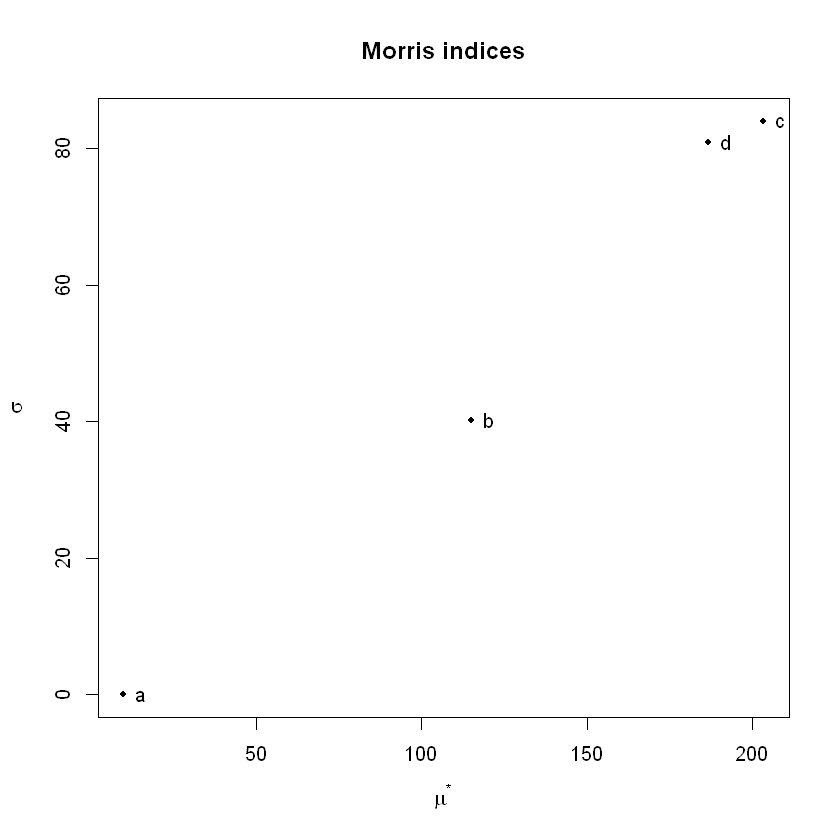

In [88]:
## visualize Morris sensitivity indices
plot(etude.morris,main=paste('Morris indices'))

#### $\Rrightarrow$ The Morris' method enable to detect the higher influence of b, c , d than a regarding the values of $\mu^{*}$. The hight value of $\sigma$ for the parameter b stress it non linear effect, while for c and d it is both interactions and non linearity

## 3. Application using latin hypercube sampling (LHS) and Metamodel

### Design the lhs plan

In [89]:
####function to generate the LHS plan
RandomLHS=function(factors,distribParameters,size,preserveDraw=FALSE){
  
  #set random seed
  RNGkind(kind="L'Ecuyer-CMRG")
  set.seed(1) 
  
  nbf=length(factors)
  design=randomLHS(n=size,k=nbf,preserveDraw = preserveDraw)
  for (i in 1:nbf){
    design[,i]=distribParameters[[1]][[i]]+design[,i]*(distribParameters[[2]][[i]]-distribParameters[[1]][[i]])
  }
  colnames(design)=factors
  resultats=as.data.frame(design)
  return(resultats)
}

In [90]:
distribParameters=Pvar[,c('min','max')]
size=length(parameters)**3
print(paste('Sample size =',size))
planLHS=RandomLHS(factors = parameters,size=size,distribParameters = distribParameters,preserveDraw=FALSE)


[1] "Sample size = 64"


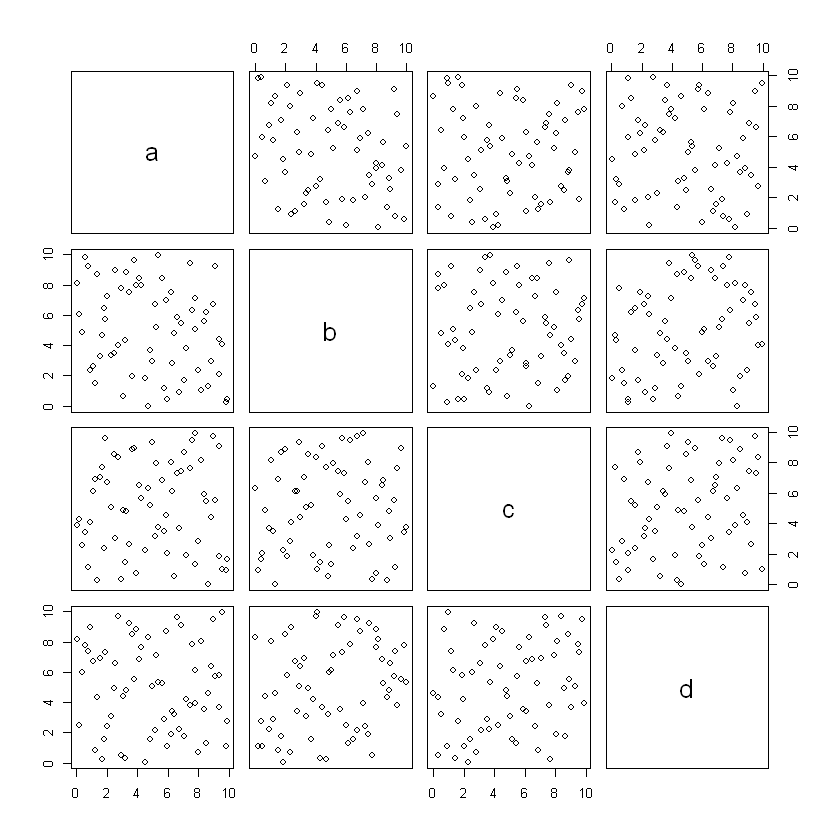

In [91]:
### visualize lhs
plot(planLHS)

In [92]:
### run simulations of the model on from the lhs 
planLHS=planLHS%>%
  mutate(y=simple.model(a,b,c,d))

### Define the metamodel
Here we will consider a ponynomial function of degree 2: $y=\mu + \beta_{1}a+\beta_{2}b+\beta_{3}c+\beta_{4}d+\beta_{5}a^2+\beta_{6}b^2+\beta_{7}c^2+\beta_{8}d^2+ \beta_{9}a.b+ \beta_{10}a.c+ \beta_{11}a.d +\beta_{12}b.c +\beta_{13}b.d +\beta_{14}c.d + \epsilon$ 
The calibration of the metamodel consists in estimating the all coefficients $\beta_i$ 

In [93]:
# calibration
MM=lm(formula=planLHS[,'y']~polym(a,b,c,d,degree=2),data=planLHS)

print(summary(MM))

Warning message in summary.lm(MM):
"essentially perfect fit: summary may be unreliable"



Call:
lm(formula = planLHS[, "y"] ~ polym(a, b, c, d, degree = 2), 
    data = planLHS)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.101e-13 -1.523e-14  2.783e-15  1.865e-14  1.204e-13 

Coefficients:
                                       Estimate Std. Error    t value Pr(>|t|)
(Intercept)                          -6.802e+01  5.866e-15 -1.159e+16   <2e-16
polym(a, b, c, d, degree = 2)1.0.0.0  2.303e+01  5.226e-14  4.408e+14   <2e-16
polym(a, b, c, d, degree = 2)2.0.0.0 -1.522e-14  4.835e-14 -3.150e-01   0.7542
polym(a, b, c, d, degree = 2)0.1.0.0  2.774e+02  5.382e-14  5.154e+15   <2e-16
polym(a, b, c, d, degree = 2)1.1.0.0  6.861e-13  4.714e-13  1.455e+00   0.1519
polym(a, b, c, d, degree = 2)0.2.0.0  6.007e+01  4.892e-14  1.228e+15   <2e-16
polym(a, b, c, d, degree = 2)0.0.1.0 -4.624e+02  5.136e-14 -9.001e+15   <2e-16
polym(a, b, c, d, degree = 2)1.0.1.0 -5.170e-14  4.361e-13 -1.190e-01   0.9061
polym(a, b, c, d, degree = 2)0.1.1.0  5.257e-13  5.106e-13  1

In [94]:
# explained variance
r2_total=summary(MM)$adj.r.squared

print(r2_total)

Warning message in summary.lm(MM):
"essentially perfect fit: summary may be unreliable"


[1] 1


`geom_smooth()` using formula 'y ~ x'



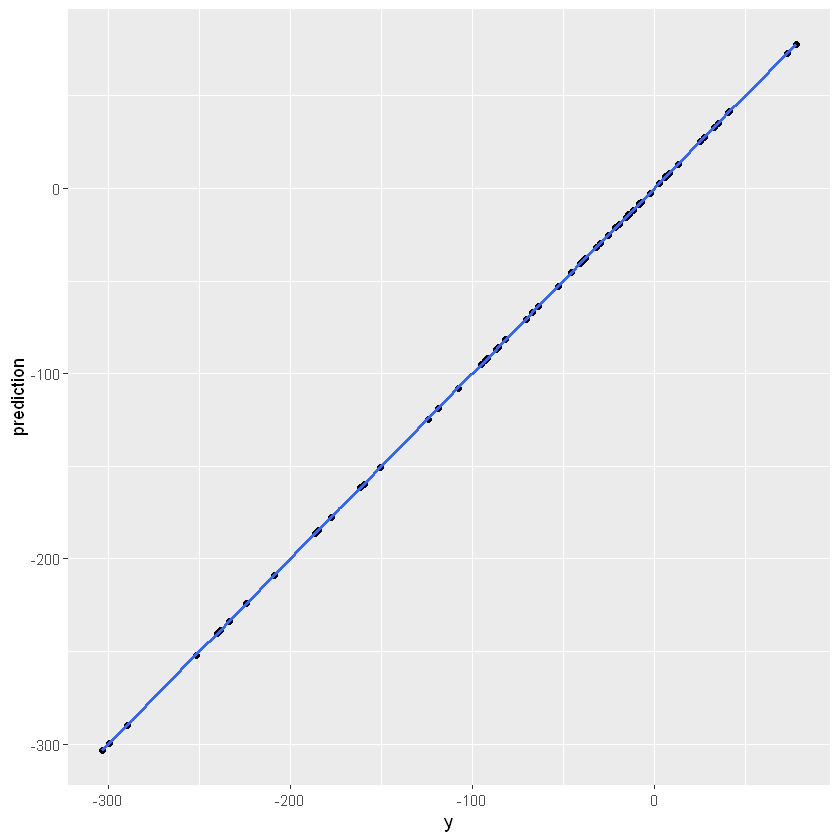

In [95]:
#check for model adjustment

planLHS$prediction=predict(MM) ##get metaomel precidtions

graph_ajust=ggplot(data=planLHS,aes(x=y,y=prediction))+
  geom_point()+
  geom_smooth(method='lm')

print(graph_ajust)


#### $\Rrightarrow$ We have a perfect fit, obvious since the studied model is a polynom of degree 2

In [96]:
## estimating the contribution of each term to the explained variance

table.comp=NULL
V=plan.complet[,1:(ncol(plan.complet)-1)]
for (i in 1:ncol(V)){
  v=paste(colnames(V)[i])
  
  model_seul=lm(formula=plan.complet[,'y']~polym(V[,i],degree=2),data=plan.complet)
  r2_seul=summary(model_seul)$adj.r.squared
  
  vecteur=data.frame(r=c(1:length(parameters)),c=c(1:length(parameters)))
  w=which(vecteur$c!=i)  
  
  model_sauf=lm(formula=plan.complet[,'y']~polym(V[,w[1]],V[,w[2]],V[,w[3]],degree=3),data=plan.complet)
  r2_sauf=summary(model_sauf)$adj.r.squared
  
  r2_spe=r2_total-r2_sauf  ##specific effect of the parameter
  r2_int_conf=r2_total-r2_sauf-r2_seul
  r2_int=ifelse(r2_int_conf>0,r2_int_conf,0) ### interaction effect
  r2_conf=ifelse(r2_int_conf>0,0,abs(r2_int_conf)) ###confusion effect (cannot differenciate if the effect comes from the parameters or the others)
  
  table.comp_sub=data.frame(Alone=r2_seul,Specific=r2_spe,Interaction=r2_int,Confusion=r2_conf,row.names=v)
  table.comp=rbind(table.comp, table.comp_sub)
}

assign(paste('table','y'),table.comp)

print(table.comp)

          Alone    Specific Interaction Confusion
a -0.0005622435 0.000997664 0.001559907         0
b  0.1486294372 0.152177008 0.003547571         0
c  0.4006734555 0.454136631 0.053463175         0
d  0.4006734555 0.454136631 0.053463175         0


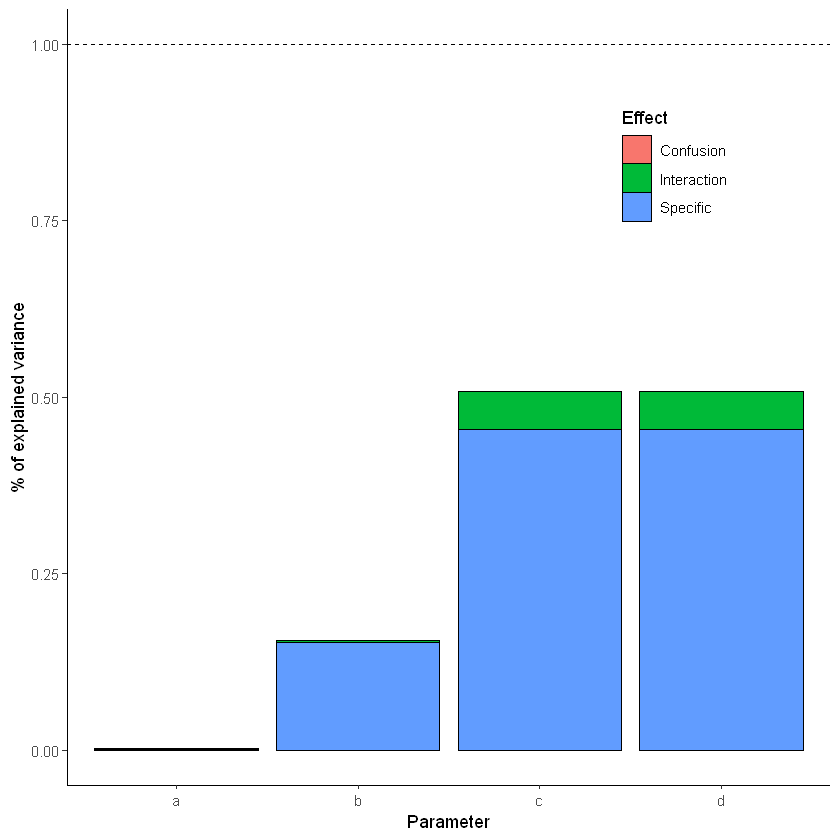

In [97]:
### contribution of parameters to explained variance
data_bar=data.frame(r2=c(table.comp[,'Specific'],table.comp[,'Interaction'],table.comp[,'Confusion']),Effect=c(rep('Specific',nrow(table.comp)),rep('Interaction',nrow(table.comp)),rep('Confusion',nrow(table.comp))),Parameter=rep(rownames(table.comp),3))

graphDecomp=ggplot() + 
  geom_hline(yintercept=r2_total,lty=2)+
  geom_bar(data=data_bar, aes(fill=Effect,y=r2, x=Parameter), stat="identity",col=1,lwd=0.1)+
  ylab('')+
  ylim(0,1)+
  theme_classic()+
  ylab('% of explained variance')+
  theme(legend.position=c(0.8,0.8))

print(graphDecomp)

#### $\Rrightarrow$ This expample is similar to the analysis of variance performed in 2, but here the metamodel is different and was based on 64 rather than 1296  simulations 

### Now it is your turn to perform sensitivity analysis on a FSPM example $\Rrightarrow$ TD_Sensitivity_Analysis_Part2